In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lightfm_hybrid/other/default/1/LightFM_Hybrid/model_LightFM_hybrid.pkl
/kaggle/input/lightfm_hybrid/other/default/1/LightFM_Hybrid/user_embeddings_LightFM_hybrid.npy
/kaggle/input/lightfm_hybrid/other/default/1/LightFM_Hybrid/item_embeddings_LightFM_hybrid.npy
/kaggle/input/preproccessed-dts-new/NEW_retail/valid.csv
/kaggle/input/preproccessed-dts-new/NEW_retail/train.csv
/kaggle/input/preproccessed-dts-new/NEW_retail/test.csv
/kaggle/input/ecommerce-dataset/item_properties_part1.csv
/kaggle/input/ecommerce-dataset/category_tree.csv
/kaggle/input/ecommerce-dataset/item_properties_part2.csv
/kaggle/input/ecommerce-dataset/events.csv
/kaggle/input/implicit_lightfm_cnn/keras/default/1/Implicit_LightFM_CNNs/user_embeddings.npy
/kaggle/input/implicit_lightfm_cnn/keras/default/1/Implicit_LightFM_CNNs/model_frozen_embeddings.keras
/kaggle/input/implicit_lightfm_cnn/keras/default/1/Implicit_LightFM_CNNs/item_embeddings.npy
/kaggle/input/implicit_lightfm_cnn/keras/default/1/Implic

# I. Load Dataset

In [2]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 5.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=829308 sha256=2b6ffaee71b5fbaf82f73c7815d09494c8ff51efca259a4fed6fb0a32cf28c07
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm


In [3]:
import os
import re
import random
import joblib
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm, trange
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_recall_fscore_support, roc_auc_score)

from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Embedding, Flatten, Dense, Dropout, Concatenate,
                                     Multiply, BatchNormalization, Reshape, GaussianNoise, 
                                     Activation, Lambda, Layer, Conv1D, GlobalMaxPooling1D, 
                                     LSTM, MultiHeadAttention)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical, register_keras_serializable, plot_model
from tensorflow.keras.metrics import AUC, Precision, Recall
from sklearn.metrics import top_k_accuracy_score


2025-05-09 02:25:02.472078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746757502.666451      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746757502.721417      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import lightfm
print("LightFM version:", lightfm.__version__)
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

LightFM version: 1.17
TensorFlow version: 2.18.0


In [3]:
# Đọc dữ liệu
events = pd.read_csv("/kaggle/input/ecommerce-dataset/events.csv")
items1 = pd.read_csv("/kaggle/input/ecommerce-dataset/item_properties_part1.csv")
items2 = pd.read_csv("/kaggle/input/ecommerce-dataset/item_properties_part2.csv")
categories = pd.read_csv("/kaggle/input/ecommerce-dataset/category_tree.csv")



In [4]:

# Gộp dữ liệu items
items = pd.concat([items1, items2], ignore_index=True)

# Giữ lại các event quan trọng
events = events[events["event"].isin(["view", "addtocart", "transaction"])]

# Mã hóa user_id và item_id
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
events["user_id"] = user_encoder.fit_transform(events["visitorid"])
events["item_id"] = item_encoder.fit_transform(events["itemid"])

# Chuyển timestamp về dạng datetime
events["timestamp"] = pd.to_datetime(events["timestamp"], unit="ms")

# Xử lý category_id
items_category = items[items["property"] == "categoryid"][["itemid", "value"]]
items_category.rename(columns={"value": "categoryid"}, inplace=True)
items_category["categoryid"] = pd.to_numeric(items_category["categoryid"], errors="coerce").astype("Int64")
items = items.merge(items_category, on="itemid", how="left")
items_with_category = items[["itemid", "categoryid"]].drop_duplicates()

# Kết hợp category_id vào events
df_final = events.merge(items_with_category, on="itemid", how="left")
df_final.rename(columns={"categoryid": "category_id"}, inplace=True)

# Xử lý missing category_id
num_categories = df_final["category_id"].nunique()
df_final["category_id"] = df_final["category_id"].fillna(num_categories + 1).astype(int)

# Lấy parent_category
df_final = df_final.merge(categories, left_on="category_id", right_on="categoryid", how="left")
df_final.rename(columns={"parentid": "parent_category"}, inplace=True)
df_final["parent_category"] = df_final["parent_category"].fillna(-1).astype(int)

# Xử lý giá sản phẩm
items_price_raw = items[items["value"].str.contains(r"n\d+\.\d+", na=False)].copy()
def extract_price(value):
    prices = re.findall(r"n(\d+\.\d+)", value)
    return float(prices[0]) if prices else None
items_price_raw["price"] = items_price_raw["value"].apply(extract_price)
items_price = items_price_raw[["itemid", "price"]].dropna().drop_duplicates(subset="itemid")

# Thêm giá vào df_final
df_final = df_final.merge(items_price, on="itemid", how="left")

# Thêm thông tin user
unique_users = df_final["user_id"].unique()
user_info = pd.DataFrame({
    "user_id": unique_users,
    "age": np.random.randint(18, 66, size=len(unique_users)),   # Tuổi 18-65
    "gender": np.random.randint(0, 2, size=len(unique_users))   # 0: nữ, 1: nam
})
df_final = df_final.merge(user_info, on="user_id", how="left")

# Mã hóa event thành interaction_value
df_final["interaction_value"] = df_final["event"].map({"view": 1, "addtocart": 2, "transaction": 3}).astype(np.float32)

# Chuẩn hóa tuổi
scaler = MinMaxScaler()
df_final["age"] = scaler.fit_transform(df_final[["age"]])

# Xử lý missing giá bằng median
median_price = df_final["price"].median()
df_final["price"] = df_final["price"].fillna(median_price)
df_final["price"] = np.log1p(df_final["price"])
df_final["price"] = scaler.fit_transform(df_final[["price"]])

# Lưu datetime gốc để xử lý tuần hoàn
df_final["datetime"] = df_final["timestamp"]

# Trích xuất các feature theo thời gian
df_final["hour"] = df_final["datetime"].dt.hour
df_final["dayofweek"] = df_final["datetime"].dt.dayofweek
df_final["month"] = df_final["datetime"].dt.month
df_final["is_weekend"] = df_final["dayofweek"].isin([5, 6]).astype(int)

# Encode sin/cos cho giờ và ngày
df_final["hour_sin"] = np.sin(2 * np.pi * df_final["hour"] / 24)
df_final["hour_cos"] = np.cos(2 * np.pi * df_final["hour"] / 24)
df_final["dayofweek_sin"] = np.sin(2 * np.pi * df_final["dayofweek"] / 7)
df_final["dayofweek_cos"] = np.cos(2 * np.pi * df_final["dayofweek"] / 7)

# Tính recency và session
df_final = df_final.sort_values(by=["user_id", "timestamp"])
df_final["timestamp_numeric"] = df_final["timestamp"].astype(np.int64) / 1e9
df_final["time_diff"] = df_final.groupby("user_id")["timestamp_numeric"].diff().fillna(0)
df_final["new_session"] = (df_final["time_diff"] > 1800).astype(int)
df_final["session_id"] = df_final.groupby("user_id")["new_session"].cumsum()

# Chuẩn hóa timestamp liên tục
df_final["timestamp_norm"] = scaler.fit_transform(df_final[["timestamp_numeric"]])

# Lọc cột cuối cùng
df_final = df_final[[
    "user_id", "item_id", "category_id", "parent_category", "price", "age", "gender",
    "interaction_value", "hour", "dayofweek", "is_weekend",
    "hour_sin", "hour_cos", "dayofweek_sin", "dayofweek_cos",
    "time_diff", "session_id", "timestamp_norm"
]]

print(df_final.head())


         user_id  item_id  category_id  parent_category     price       age  \
1461606        0   144072         1188             1497  0.006384  0.808511   
1467496        0   180182          256             1257  0.026787  0.808511   
1467638        0    33901          333             1497  0.028073  0.808511   
893928         1    36440         1192              955  0.027146  0.404255   
800509         2   163762          299               73  0.011042  0.765957   

         gender  interaction_value  hour  dayofweek  is_weekend  hour_sin  \
1461606       1                1.0    20          4           0 -0.866025   
1467496       1                1.0    20          4           0 -0.866025   
1467638       1                1.0    20          4           0 -0.866025   
893928        0                1.0    17          3           0 -0.965926   
800509        0                1.0    17          4           0 -0.965926   

         hour_cos  dayofweek_sin  dayofweek_cos  time_diff  se

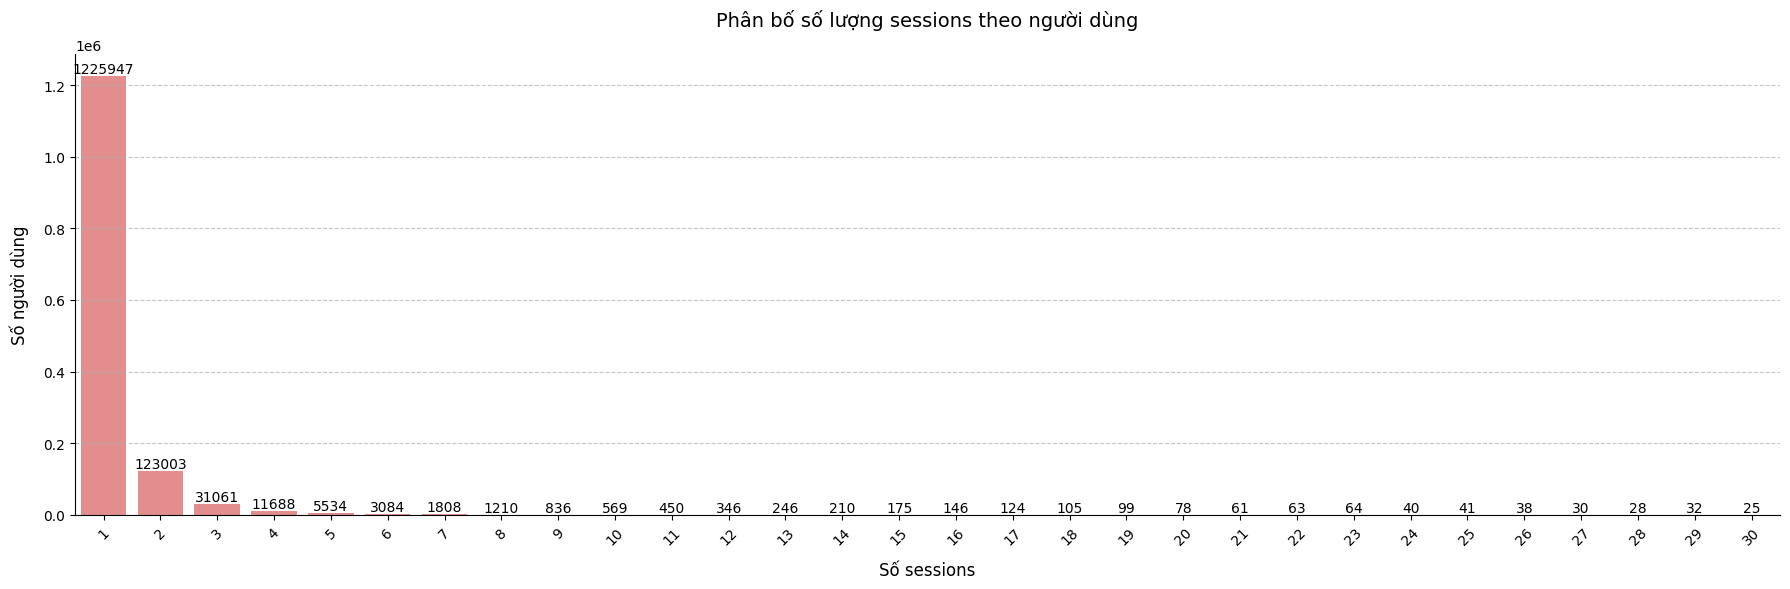

In [5]:

# Count number of sessions per user
session_counts = df_final.groupby("user_id")["session_id"].nunique().reset_index()
session_counts.columns = ["user_id", "num_sessions"]

# Count how many users have each number of sessions
session_count_values = session_counts["num_sessions"].value_counts().reset_index()
session_count_values.columns = ["num_sessions", "user_count"]

# Create a complete range from 1 to 30
full_range = pd.DataFrame({'num_sessions': range(1, 31)})

# Merge with our actual data to fill in zeros where needed
session_count_values = full_range.merge(session_count_values, 
                                       on='num_sessions', 
                                       how='left').fillna(0)

# Create the plot
plt.figure(figsize=(18, 6))  # Increase figure width for better visibility
ax = sns.barplot(x="num_sessions", 
                 y="user_count", 
                 data=session_count_values,
                 color="lightcoral")

# Customize the plot
plt.title("Phân bố số lượng sessions theo người dùng", fontsize=14, pad=20)
plt.xlabel("Số sessions", fontsize=12, labelpad=10)
plt.ylabel("Số người dùng", fontsize=12, labelpad=10)

# Set x-axis to show all integers from 1 to 30
plt.xticks(range(30), range(1, 31))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid lines
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Remove spines for cleaner look
sns.despine()

# Add value labels on top of bars
for p in ax.patches:
    if p.get_height() > 0:  # Only label bars with height > 0
        ax.annotate(f"{int(p.get_height())}", 
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', 
                   xytext=(0, 5), 
                   textcoords='offset points')

plt.tight_layout()
plt.show()


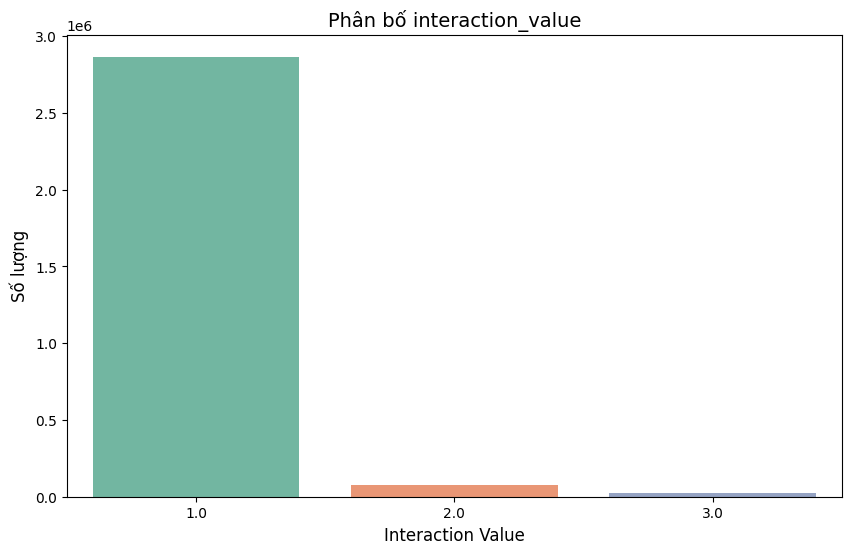

In [6]:
# Trực quan hóa phân bố của interaction_value
plt.figure(figsize=(10, 6))
sns.countplot(x="interaction_value", data=df_final, palette="Set2")
plt.title("Phân bố interaction_value", fontsize=14)
plt.xlabel("Interaction Value", fontsize=12)
plt.ylabel("Số lượng", fontsize=12)
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


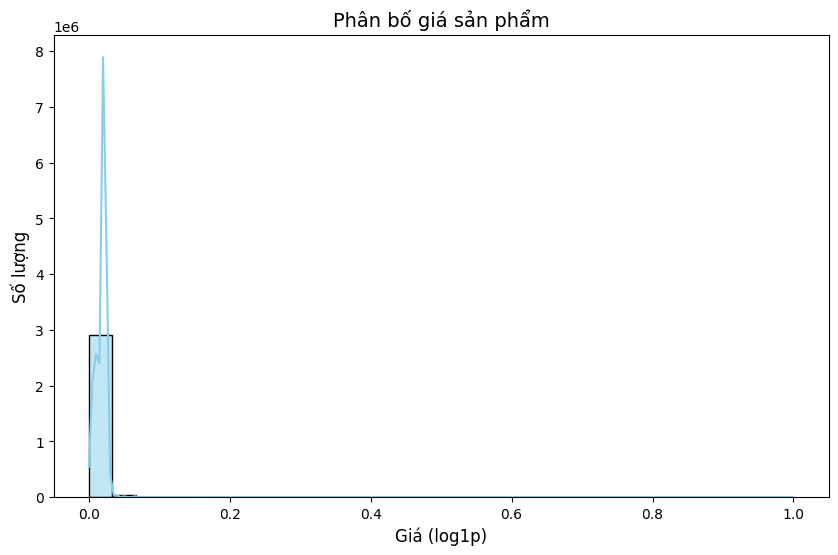

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df_final["price"], kde=True, color="skyblue", bins=30)
plt.title("Phân bố giá sản phẩm", fontsize=14)
plt.xlabel("Giá (log1p)", fontsize=12)
plt.ylabel("Số lượng", fontsize=12)
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


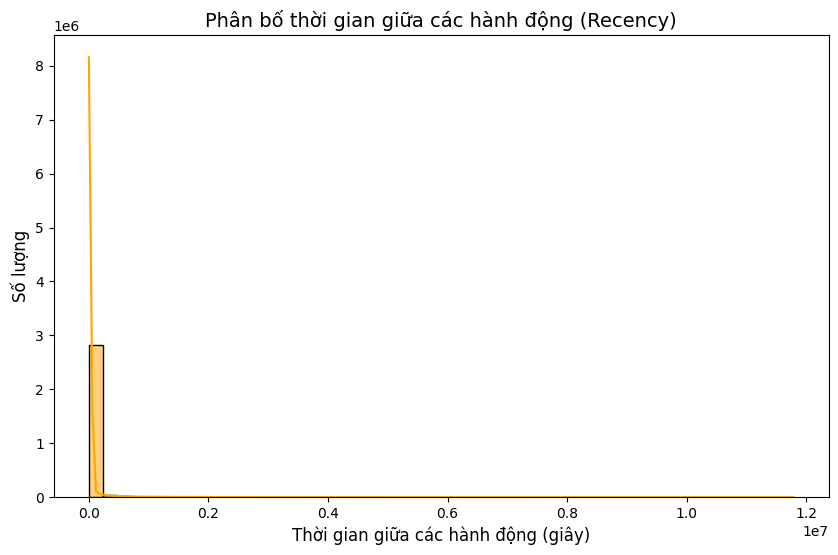

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(df_final["time_diff"], kde=True, color="orange", bins=50)
plt.title("Phân bố thời gian giữa các hành động (Recency)", fontsize=14)
plt.xlabel("Thời gian giữa các hành động (giây)", fontsize=12)
plt.ylabel("Số lượng", fontsize=12)
plt.show()


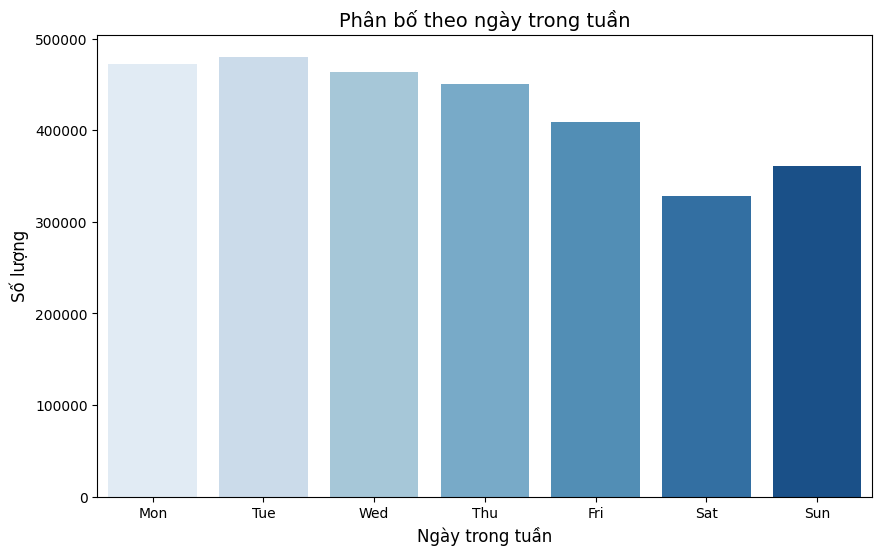

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(x="dayofweek", data=df_final, palette="Blues")
plt.title("Phân bố theo ngày trong tuần", fontsize=14)
plt.xlabel("Ngày trong tuần", fontsize=12)
plt.ylabel("Số lượng", fontsize=12)
plt.xticks(ticks=range(7), labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.show()


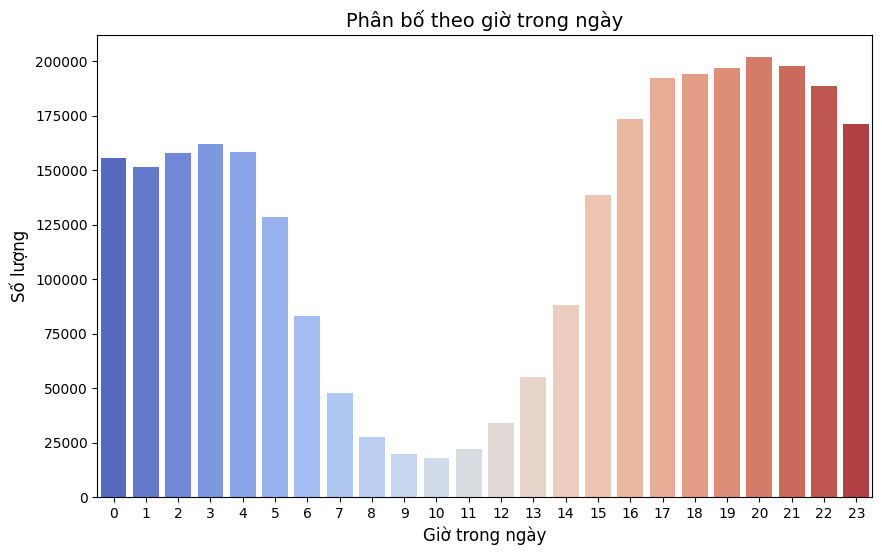

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(x="hour", data=df_final, palette="coolwarm")
plt.title("Phân bố theo giờ trong ngày", fontsize=14)
plt.xlabel("Giờ trong ngày", fontsize=12)
plt.ylabel("Số lượng", fontsize=12)
plt.show()


# II. Data Preprocessing

# LightFM 

In [ ]:
# 80% train-test
train, test = train_test_split(df_final, test_size=0.2, random_state=42)
# 70% train và 10% validation
train, valid = train_test_split(train, test_size=0.125, random_state=42)  # 0.125 * 80% = 10%

In [9]:
dtypes = {
    "user_id": "int32",
    "item_id": "int32",
    "category_id": "int32",
    "parent_category": "int32",
    "price": "float32",
    "age": "float32",
    "gender": "float32",
    "interaction_value": "float32",
    "hour": "float32",
    "dayofweek": "float32",
    "is_weekend": "float32",
    "hour_sin": "float32",
    "hour_cos": "float32",
    "dayofweek_sin": "float32",
    "dayofweek_cos": "float32",
    "time_diff": "float32",
    "session_id": "int32",
    "timestamp_norm": "float32"
}


In [ ]:
for col, dtype in dtypes.items():
    df_final[col] = df_final[col].astype(dtype)

In [ ]:
train.to_csv("train.csv", index=False)
valid.to_csv("valid.csv", index=False)
test.to_csv("test.csv", index=False)

In [10]:
train = pd.read_csv("/kaggle/input/preproccessed-dts-new/NEW_retail/train.csv", dtype=dtypes)
valid = pd.read_csv("/kaggle/input/preproccessed-dts-new/NEW_retail/valid.csv", dtype=dtypes)
test = pd.read_csv("/kaggle/input/preproccessed-dts-new/NEW_retail/test.csv", dtype=dtypes)

In [8]:
print(f"Train Shape: {train.shape}")
print(f"Validation Shape: {valid.shape}")
print(f"Test Shape: {test.shape}")

print("Example data:")
print(train.head())

Train Shape: (2075521, 18)
Validation Shape: (296503, 18)
Test Shape: (593007, 18)
Example data:
   user_id  item_id  category_id  parent_category     price       age  gender  \
0   744725   222716         1511              409  0.023792  0.957447     0.0   
1   103546   163136         1578             1249  0.024750  0.808511     1.0   
2   237967   220520           48              500  0.008267  0.638298     1.0   
3  1248467    52297          516             1031  0.010896  0.042553     1.0   
4   885943   181188         1425              385  0.030345  0.574468     1.0   

   interaction_value  hour  dayofweek  is_weekend  hour_sin  hour_cos  \
0                1.0   3.0        6.0         1.0  0.707107  0.707107   
1                1.0  22.0        6.0         1.0 -0.500000  0.866025   
2                1.0  19.0        1.0         0.0 -0.965926  0.258819   
3                1.0  17.0        4.0         0.0 -0.965926 -0.258819   
4                1.0   0.0        1.0         0.0  

In [15]:
print(train["interaction_value"].value_counts(normalize=True))

interaction_value
1.0    0.966710
2.0    0.025246
3.0    0.008045
Name: proportion, dtype: float64


In [11]:
num_threads = min(os.cpu_count(), 8)

# Chuẩn bị dataset với user_id và item_id
all_user_ids = np.unique(np.concatenate((train["user_id"].unique(),
                                         valid["user_id"].unique(),
                                         test["user_id"].unique())))
all_item_ids = np.unique(np.concatenate((train["item_id"].unique(),
                                         valid["item_id"].unique(),
                                         test["item_id"].unique())))
dataset = Dataset()
dataset.fit(users=all_user_ids, items=all_item_ids)

# Xây dựng interactions matrix
(interactions_train, _) = dataset.build_interactions(zip(train["user_id"], train["item_id"], train["interaction_value"]))
(interactions_valid, _) = dataset.build_interactions(zip(valid["user_id"], valid["item_id"], valid["interaction_value"]))
(interactions_test, _) = dataset.build_interactions(zip(test["user_id"], test["item_id"], test["interaction_value"]))

# Chuyển interactions sang dạng sparse matrix (CSR) - Ma trận thưa
interactions_train_csr = csr_matrix(interactions_train)
interactions_valid_csr = csr_matrix(interactions_valid)
interactions_test_csr = csr_matrix(interactions_test)

In [ ]:
embedding_dim = 128  
num_epochs = 100
model_LightFM = LightFM(loss="warp", no_components=embedding_dim)
for epoch in tqdm(range(num_epochs), desc="Training Progress"):
    model_LightFM.fit_partial(interactions_train_csr, epochs=1, num_threads=num_threads)
    print(f"Epoch {epoch+1}/{num_epochs} finished!")


In [ ]:
joblib.dump(model_LightFM, 'lightfm_model.pkl.pkl')

In [11]:
model_LightFM = joblib.load('/kaggle/input/implicit_lightfm_cnn/keras/default/1/Implicit_LightFM_CNNs/lightfm_model.pkl')

In [ ]:
precision = precision_at_k(model_LightFM, interactions_test_csr, k=5, num_threads=num_threads).mean()
recall = recall_at_k(model_LightFM, interactions_test_csr, k=5, num_threads=num_threads).mean()
auc = auc_score(model_LightFM, interactions_test_csr, num_threads=num_threads).mean()

print(f"Precision@5: {precision:.4f}")
print(f"Recall@5: {recall:.4f}")
print(f"AUC: {auc:.4f}")


In [13]:
# Trích xuất embeddings
user_embeddings = model_LightFM.user_embeddings
item_embeddings = model_LightFM.item_embeddings
print("Shape of user embedding: ",user_embeddings.shape)
print("Shape of item embedding: ",item_embeddings.shape)

Shape of user embedding:  (1407580, 128)
Shape of item embedding:  (235061, 128)


In [ ]:
# # Save embeddings
# np.save("user_embeddings.npy", user_embeddings)
# np.save("item_embeddings.npy", item_embeddings)


In [20]:
# user_embeddings = np.load("/kaggle/input/implicit_lightfm_cnns/keras/default/1/Implicit_LightFM_CNNs/user_embeddings.npy")
# item_embeddings = np.load("/kaggle/input/implicit_lightfm_cnns/keras/default/1/Implicit_LightFM_CNNs/item_embeddings.npy")
# print("Shape of user embedding: ",user_embeddings.shape)
# print("Shape of item embedding: ",item_embeddings.shape)

Shape of user embedding:  (1407580, 128)
Shape of item embedding:  (235061, 128)


In [14]:
num_users, embedding_dim = user_embeddings.shape
num_products = item_embeddings.shape[0]

print("Number of users = ", num_users)
print("Number of products = ", num_products)
print("Demension embedding = ", embedding_dim)

Number of users =  1407580
Number of products =  235061
Demension embedding =  128


In [15]:
# Kiểm tra số lượng danh mục sản phẩm
num_categories = train["category_id"].nunique()
print("Number of categories =", num_categories)

# Kiểm tra số lượng unique parent_category
num_parent_categories = train["parent_category"].nunique()
print("Number of parent categories =", num_parent_categories)

Number of categories = 1151
Number of parent categories = 287


# Build CNN + LightFM Model

# IV. Build Model LightFM + CNN

In [29]:
y_labels = train["interaction_value"].values - 1  # trừ 1 để về dạng [0, 1, 2]
class_weights_np = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_labels),
    y=y_labels
)
class_weights_dict = dict(enumerate(class_weights_np))
print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.3448122847956183, 1: 13.203563749252517, 2: 41.435008284921444}


In [30]:
def focal_loss_with_class_weights(class_weights, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
        cross_entropy = -y_true * tf.math.log(y_pred)
        focal = tf.pow(1 - y_pred, gamma)
        class_weights_tensor = tf.constant(class_weights, dtype=tf.float32)
        weighted_focal = class_weights_tensor * focal * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(weighted_focal, axis=-1))
    return loss

In [18]:
metadata_config = {
    "user_input":          {"shape": (1,), "dtype": 'int32', "embedding": True, "dim": num_users, "weights": user_embeddings},
    "product_input":       {"shape": (1,), "dtype": 'int32', "embedding": True, "dim": num_products, "weights": item_embeddings},
    "category_input":      {"shape": (1,), "dtype": 'int32', "embedding": True, "dim": num_categories},
    "parent_category_input": {"shape": (1,), "dtype": 'int32', "embedding": True, "dim": num_parent_categories},
    "timestamp_input":     {"shape": (1,), "dtype": 'float32', "dense": True},
    "price_input":         {"shape": (1,), "dtype": 'float32', "dense": True},
    "age_input":           {"shape": (1,), "dtype": 'float32', "dense": True},
    "gender_input":        {"shape": (1,), "dtype": 'float32', "dense": True},

    "hour_input":          {"shape": (1,), "dtype": 'float32', "dense": True},
    "dayofweek_input":     {"shape": (1,), "dtype": 'float32', "dense": True},
    "is_weekend_input":    {"shape": (1,), "dtype": 'float32', "dense": True},
    
    "hour_sin_input":      {"shape": (1,), "dtype": 'float32', "dense": True},
    "hour_cos_input":      {"shape": (1,), "dtype": 'float32', "dense": True},
    "dayofweek_sin_input": {"shape": (1,), "dtype": 'float32', "dense": True},
    "dayofweek_cos_input": {"shape": (1,), "dtype": 'float32', "dense": True},
    
    "time_diff_input":     {"shape": (1,), "dtype": 'float32', "dense": True},
    "session_id_input":    {"shape": (1,), "dtype": 'int32', "dense": True}
}

In [19]:
def build_model(trainable_embedding=False):
    inputs = {}
    embeddings = {}
    dense_features = []

    # Print input shapes for debugging
    print(f"User embedding matrix shape: {user_embeddings.shape}")
    print(f"Product embedding matrix shape: {item_embeddings.shape}")
    
    for name, cfg in metadata_config.items():
        inp = Input(shape=cfg["shape"], dtype=cfg["dtype"], name=name)
        inputs[name] = inp

        if cfg.get("embedding"):
            # Special handling for user and product embeddings
            if name == "user_input":
                emb_weights = [user_embeddings]
                emb_dim = user_embeddings.shape[1]
            elif name == "product_input":
                emb_weights = [item_embeddings]
                emb_dim = item_embeddings.shape[1]
            else:
                emb_weights = None
                emb_dim = embedding_dim
                
            emb_layer = Embedding(
                input_dim=cfg["dim"], 
                output_dim=emb_dim,
                weights=emb_weights,
                trainable=trainable_embedding
            )(inp)
            
            emb_layer = GaussianNoise(0.01)(emb_layer)
            emb_layer = Flatten()(emb_layer)
            embeddings[name] = emb_layer

        elif cfg.get("dense"):
            dense = Dense(16, activation='relu')(inp)
            dense = BatchNormalization()(dense)
            dense = Dropout(0.2)(dense)
            dense_features.append(dense)
            
    # === Conv1D Layer ===
    user_emb = embeddings["user_input"]
    product_emb = embeddings["product_input"]
    
    # Reshape embeddings to have an additional dimension for Conv1D (batch_size, sequence_length, embedding_dim)
    user_emb_reshaped = Reshape((-1, 1))(user_emb)  # Reshape to (batch_size, 1, embedding_dim)
    product_emb_reshaped = Reshape((-1, 1))(product_emb)  # Reshape to (batch_size, 1, embedding_dim)
    
    # Apply Conv1D
    user_emb_conv = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(user_emb_reshaped)
    user_emb_conv = GlobalMaxPooling1D()(user_emb_conv)  # Dùng GlobalMaxPooling1D để giảm chiều

    product_emb_conv = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(product_emb_reshaped)
    product_emb_conv = GlobalMaxPooling1D()(product_emb_conv)

    # === Attention Mechanism ===
    user_emb = embeddings["user_input"]
    product_emb = embeddings["product_input"]
    
    # Reshape for attention (batch_size, 1, embedding_dim)
    expand_dims = Lambda(lambda x: tf.expand_dims(x, axis=1))
    user_vector = expand_dims(user_emb)
    product_vector = expand_dims(product_emb)
    
    # Verify shapes
    print(f"User vector shape: {user_vector.shape}")
    print(f"Product vector shape: {product_vector.shape}")

    # MultiHeadAttention - using 4 heads with key_dim=32 (128/4)
    attention_output = MultiHeadAttention(
        num_heads=4, 
        key_dim=32  # 128-dim embeddings divided by 4 heads
    )(user_vector, product_vector)
    
    attention_output = Flatten()(attention_output)
    attention_output = BatchNormalization()(attention_output)

    # Element-wise product of user and product embeddings
    user_product_interaction = Multiply()([user_emb, product_emb])

    # Merge all features
    merged = Concatenate()([
        user_emb, 
        product_emb, 
        user_product_interaction,
        embeddings.get("category_input", []),
        embeddings.get("parent_category_input", []),
        attention_output,
        *dense_features
    ])
    
    print(f"Merged features shape: {merged.shape}")

    # === Dense Layers ===
    x = Dense(512, kernel_regularizer=l2(1e-4))(merged)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)
    
    x = Dense(256, kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)
    
    x = Dense(128, kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    
    x = Dense(64, kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    
    print("Before output layer:", x.shape)
    
    # Output layer
    output = Dense(3, activation='softmax')(x)

    model = Model(inputs=list(inputs.values()), outputs=output)
    
    # model.compile(
    #     optimizer=Adam(learning_rate=1e-3),
    #     loss=focal_loss_with_class_weights(class_weights=class_weights_np, gamma=2.0),
    #     metrics=['accuracy']
    # )
    
    # for layer in model.layers:
    #     print(f"{layer.name}: {layer.output.shape}")
 
    return model
    
# Build the model
model = build_model(trainable_embedding=False)

User embedding matrix shape: (1407580, 128)
Product embedding matrix shape: (235061, 128)


I0000 00:00:1746757572.561118      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


User vector shape: (None, 1, 128)
Product vector shape: (None, 1, 128)
Merged features shape: (None, 976)
Before output layer: (None, 64)


In [ ]:
model.summary()

In [20]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    mode='min'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=15,
    min_lr=1e-6
)

model_checkpoint = ModelCheckpoint(
    filepath='model_frozen_embeddings.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [26]:
X_valid = [
    valid["user_id"].values,
    valid["item_id"].values,
    valid["category_id"].values,
    valid["parent_category"].values,
    valid["timestamp_norm"].values,
    valid["price"].values,
    valid["age"].values,
    valid["gender"].values,
    
    valid["hour"].values,
    valid["dayofweek"].values,
    valid["is_weekend"].values,
    
    valid["hour_sin"].values,
    valid["hour_cos"].values,
    valid["dayofweek_sin"].values,
    valid["dayofweek_cos"].values,
    
    valid["time_diff"].values,
    valid["session_id"].values
]

X_train = [
    train["user_id"].values,
    train["item_id"].values,
    train["category_id"].values,
    train["parent_category"].values,
    train["timestamp_norm"].values,
    train["price"].values,
    train["age"].values,
    train["gender"].values,
    
    train["hour"].values,
    train["dayofweek"].values,
    train["is_weekend"].values,
    
    train["hour_sin"].values,
    train["hour_cos"].values,
    train["dayofweek_sin"].values,
    train["dayofweek_cos"].values,
    
    train["time_diff"].values,
    train["session_id"].values
]

y_train = to_categorical(y_labels, num_classes=3)
y_valid = to_categorical(valid["interaction_value"].values - 1, num_classes=3)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=focal_loss_with_class_weights(class_weights=class_weights_np, gamma=2.0),
    metrics=['accuracy', AUC(), Precision(), Recall()]
)

model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=100,
    batch_size=128,
    shuffle=True,
    callbacks= callbacks
)

In [31]:
class_weights_np = np.array(list(class_weights_dict.values()))

# Load lại mô hình với các custom objects
model = load_model(
    '/kaggle/input/implicit_lightfm_cnn/keras/default/1/Implicit_LightFM_CNNs/model_frozen_embeddings.keras',
    custom_objects={
        'loss': focal_loss_with_class_weights(class_weights=class_weights_np, gamma=2.0),
        'auc': AUC(),
        'precision': Precision(),
        'recall': Recall()
    }
)


In [34]:
# Chuẩn bị dữ liệu test (giống cách bạn đã chuẩn bị trước đó)
X_test = [
    test["user_id"].values,
    test["item_id"].values,
    test["category_id"].values,
    test["parent_category"].values,
    test["timestamp_norm"].values,
    test["price"].values,
    test["age"].values,
    test["gender"].values,
    test["hour"].values,
    test["dayofweek"].values,
    test["is_weekend"].values,
    test["hour_sin"].values,
    test["hour_cos"].values,
    test["dayofweek_sin"].values,
    test["dayofweek_cos"].values,
    test["time_diff"].values,
    test["session_id"].values
]

y_test = tf.keras.utils.to_categorical(test["interaction_value"].values - 1, num_classes=3)

In [21]:
# Evaluate mô hình và in kết quả
test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUC: {test_auc:.4f}, " \
      f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")

18532/18532 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - accuracy: 0.6490 - auc: 0.8028 - loss: 0.4039 - precision: 0.9709 - recall: 0.3867
Test Loss: 0.4054, Test Accuracy: 0.6484, Test AUC: 0.8027, Test Precision: 0.9711, Test Recall: 0.3869


18532/18532 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step
classification_report:
              precision    recall  f1-score   support

           0     0.9881    0.6561    0.7886    573623
           1     0.0373    0.3699    0.0678     14577
           2     0.0405    0.5706    0.0757      4807

    accuracy                         0.6484    593007
   macro avg     0.3553    0.5322    0.3107    593007
weighted avg     0.9571    0.6484    0.7651    593007



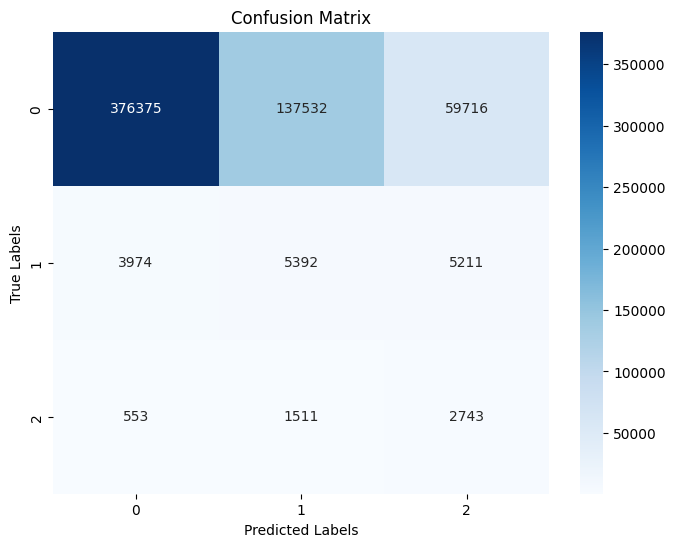

In [22]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# In ra confusion matrix và classification report
print("classification_report:")
print(classification_report(y_true, y_pred, digits=4))

# Vẽ confusion matrix bằng seaborn
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Fine-tuning model

In [ ]:
early_stopping_ft = EarlyStopping(
    monitor='val_auc_1',
    patience=20, 
    restore_best_weights=True,
    mode='max'
)

reduce_lr_ft = ReduceLROnPlateau(
    monitor='val_auc_1',
    factor=0.2,
    patience=15, 
    min_lr=1e-6,
    verbose=1,
    mode='max'
)

model_checkpoint_ft = ModelCheckpoint(
    filepath='best_model_finetune.keras',  
    monitor='val_auc_1',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks_finetune = [early_stopping_ft, reduce_lr_ft, model_checkpoint_ft]

In [ ]:
# Fine-tune embedding
for layer in model.layers:
    if 'user_emb' in layer.name or 'product_emb' in layer.name:
        layer.trainable = True

# Re-compile với learning rate nhỏ hơn
model.compile(optimizer=Adam(learning_rate=1e-4),
            loss=focal_loss_with_class_weights(class_weights=class_weights_np, gamma=2.0),
              metrics=['accuracy', AUC(), Precision(), Recall()])

# Fine-tuning
model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    epochs=100,
    batch_size=128,
    shuffle=True,
    callbacks=callbacks_finetune
)

In [35]:
class_weights_np = np.array(list(class_weights_dict.values()))

# Load lại mô hình với các custom objects
model = load_model(
    '/kaggle/input/implicit_lightfm_cnn/keras/default/1/Implicit_LightFM_CNNs/best_model_finetune.keras',
    custom_objects={
        'loss': focal_loss_with_class_weights(class_weights=class_weights_np, gamma=2.0),
        'auc': AUC(),
        'precision': Precision(),
        'recall': Recall()
    }
)

In [24]:
# Evaluate mô hình và in kết quả
test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test AUC: {test_auc:.4f}, " \
      f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")


18532/18532 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step - accuracy: 0.6667 - auc_1: 0.8120 - loss: 0.4041 - precision_1: 0.9661 - recall_1: 0.4210
Test Loss: 0.4054, Test Accuracy: 0.6660, Test AUC: 0.8119, Test Precision: 0.9663, Test Recall: 0.4212


18532/18532 ━━━━━━━━━━━━━━━━━━━━ 53s 3ms/step
classification_report:
              precision    recall  f1-score   support

           0     0.9874    0.6752    0.8020    573623
           1     0.0374    0.3311    0.0672     14577
           2     0.0393    0.5854    0.0737      4807

    accuracy                         0.6660    593007
   macro avg     0.3547    0.5306    0.3143    593007
weighted avg     0.9564    0.6660    0.7780    593007



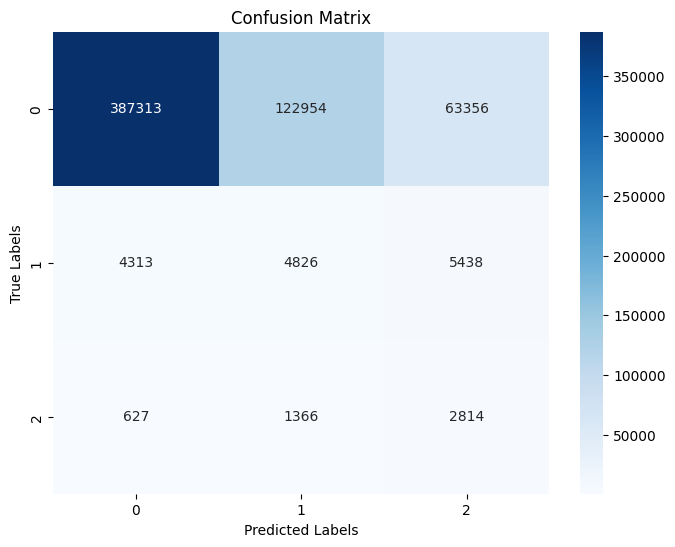

In [25]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# In ra confusion matrix và classification report
print("classification_report:")
print(classification_report(y_true, y_pred, digits=4))

# Vẽ confusion matrix bằng seaborn
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [30]:
unique_users = np.unique(X_test[0])
print(f" - Total user in test set: {len(unique_users)}")

sample_user = np.random.choice(unique_users)
# Lấy tất cả tương tác của người dùng này
user_indices = np.where(X_test[0] == sample_user)[0]
if len(user_indices) == 0:
    print(f" - User {sample_user} has no interactions in the test set")
else:
    print(f" - Found {len(user_indices)} interactions for this user")
    
    # Chuẩn bị dữ liệu đầu vào cho mô hình
    sample_inputs = [
        np.array([sample_user] * len(user_indices)),  # user_id
        X_test[1][user_indices],  # item_id
        X_test[2][user_indices],  # category_id
        X_test[3][user_indices],  # parent_category
        X_test[4][user_indices],  # timestamp_norm
        X_test[5][user_indices],  # price
        X_test[6][user_indices],  # age
        X_test[7][user_indices],  # gender
        X_test[8][user_indices],  # hour
        X_test[9][user_indices],  # dayofweek
        X_test[10][user_indices],  # is_weekend
        X_test[11][user_indices],  # hour_sin
        X_test[12][user_indices],  # hour_cos
        X_test[13][user_indices],  # dayofweek_sin
        X_test[14][user_indices],  # dayofweek_cos
        X_test[15][user_indices],  # time_diff
        X_test[16][user_indices],  # session_id
    ]

    # Dự đoán xác suất cho từng sản phẩm
    predicted_probs = model.predict(sample_inputs, batch_size=128, verbose=1)
    
    # Lấy top 5 sản phẩm có xác suất giao dịch cao nhất
    top_k = min(5, len(predicted_probs))
    
    # Sắp xếp theo xác suất lớp 2 (transaction)
    top_indices = np.argsort(predicted_probs[:, 2])[-top_k:][::-1]
    
    print(f"\n TOP {top_k} RECOMMENDED PRODUCTS FOR USER {sample_user}:")
    print("{:<10} {:<15} {:<10} {:<10} {:<15}".format(
        "STT", "Product ID", "View Prob", "Cart Prob", "Transaction Prob"))
    print("-" * 60)
    
    for i, idx in enumerate(top_indices, 1):
        product_id = sample_inputs[1][idx]
        probs = predicted_probs[idx]
        
        print("{:<10} {:<15} {:<10.2f} {:<10.2f} {:<15.2f}".format(
            i, product_id, probs[0], probs[1], probs[2]))

 - Total user in test set: 421565
 - Found 1 interactions for this user
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

 TOP 1 RECOMMENDED PRODUCTS FOR USER 164536:
STT        Product ID      View Prob  Cart Prob  Transaction Prob
------------------------------------------------------------
1          133341          0.62       0.30       0.08           


In [33]:
# Chọn ngẫu nhiên 1 sản phẩm từ tập test
unique_items = np.unique(X_test[1])
sample_item = np.random.choice(unique_items)

# Tìm tất cả các dòng có sản phẩm này
item_indices = np.where(X_test[1] == sample_item)[0]

if len(item_indices) == 0:
    print(f" - Product {sample_item} has no interactions in the test set")
else:
    print(f" - Found {len(item_indices)} interactions with this product")
    
    # Chuẩn bị đầu vào cho mô hình (dành cho tất cả user tương tác với sản phẩm này)
    sample_inputs = [
        X_test[0][item_indices],  # user_id
        np.array([sample_item] * len(item_indices)),  # item_id
        X_test[2][item_indices],  # category_id
        X_test[3][item_indices],  # parent_category
        X_test[4][item_indices],  # timestamp_norm
        X_test[5][item_indices],  # price
        X_test[6][item_indices],  # age
        X_test[7][item_indices],  # gender
        X_test[8][item_indices],  # hour
        X_test[9][item_indices],  # dayofweek
        X_test[10][item_indices],  # is_weekend
        X_test[11][item_indices],  # hour_sin
        X_test[12][item_indices],  # hour_cos
        X_test[13][item_indices],  # dayofweek_sin
        X_test[14][item_indices],  # dayofweek_cos
        X_test[15][item_indices],  # time_diff
        X_test[16][item_indices],  # session_id
    ]

    # Dự đoán xác suất người dùng sẽ tương tác với sản phẩm
    predicted_probs = model.predict(sample_inputs, batch_size=128, verbose=1)

    # Lấy top 5 người dùng có xác suất giao dịch cao nhất
    top_k = min(5, len(predicted_probs))
    top_indices = np.argsort(predicted_probs[:, 2])[-top_k:][::-1]  # Lớp 2: transaction

    print(f"\n TOP {top_k} POTENTIAL USERS FOR PRODUCT {sample_item}:")
    print("{:<10} {:<15} {:<10} {:<10} {:<15}".format(
        "STT", "User ID", "View Prob", "Cart Prob", "Transaction Prob"))
    print("-" * 60)

    for i, idx in enumerate(top_indices, 1):
        user_id = sample_inputs[0][idx]
        probs = predicted_probs[idx]

        print("{:<10} {:<15} {:<10.2f} {:<10.2f} {:<15.2f}".format(
            i, user_id, probs[0], probs[1], probs[2]))

 - Found 3 interactions with this product
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step

 TOP 3 POTENTIAL USERS FOR PRODUCT 115739:
STT        User ID         View Prob  Cart Prob  Transaction Prob
------------------------------------------------------------
1          1198777         0.54       0.34       0.12           
2          1000115         0.65       0.29       0.07           
3          374961          0.66       0.28       0.06           


# Cold start problem

In [45]:
# Tách người dùng và sản phẩm cold-start
train_users, train_items = set(train["user_id"]), set(train["item_id"])
test_users, test_items = set(test["user_id"]), set(test["item_id"])

cold_start_users = test_users - train_users
cold_start_items = test_items - train_items

mask_cold_user = test["user_id"].isin(cold_start_users)
mask_cold_item = test["item_id"].isin(cold_start_items)

test_cold_user, test_cold_item = test[mask_cold_user], test[mask_cold_item]
test_non_cold_user, test_non_cold_item = test[~mask_cold_user], test[~mask_cold_item]

y_test_cold_user, y_test_cold_item = y_test[mask_cold_user.values], y_test[mask_cold_item.values]
y_test_non_cold_user, y_test_non_cold_item = y_test[~mask_cold_user.values], y_test[~mask_cold_item.values]

In [47]:
print(f" - Cold-start users: {len(cold_start_users)} / {len(test_users)} ({len(cold_start_users)/len(test_users)*100:.2f}%)")
print(f" - Cold-start items: {len(cold_start_items)} / {len(test_items)} ({len(cold_start_items)/len(test_items)*100:.2f}%)")

 - Cold-start users: 208834 / 421565 (49.54%)
 - Cold-start items: 17776 / 129302 (13.75%)


In [48]:
# Hàm chuẩn bị input
def prepare_input(df):
    return [df[col].values for col in [
        "user_id", "item_id", "category_id", "parent_category", "timestamp_norm", "price", "age", "gender",
        "hour", "dayofweek", "is_weekend", "hour_sin", "hour_cos", "dayofweek_sin", "dayofweek_cos", "time_diff", "session_id"
    ]]

In [65]:
def get_loss(model, df, y_true):
    X = prepare_input(df)
    loss = model.evaluate(X, y_true, batch_size=128, verbose=0)
    return loss[0]

def get_topk_acc(model, df, y_true, k=2):
    X = prepare_input(df)
    y_probs = model.predict(X, batch_size=128, verbose=0)
    y_true = np.argmax(y_true, axis=1) if len(y_true.shape) > 1 else y_true
    return top_k_accuracy_score(y_true, y_probs, k=k)


In [66]:
def evaluate_cold_start(model, df, y_true, name="Cold Start"):
    X_eval = prepare_input(df)
    y_pred_probs = model.predict(X_eval, batch_size=128, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true_class = np.argmax(y_true, axis=1) if len(y_true.shape) > 1 else y_true

    precision, recall, f1, _ = precision_recall_fscore_support(y_true_class, y_pred, average='macro', zero_division=0)
    auc = roc_auc_score(pd.get_dummies(y_true_class), y_pred_probs, multi_class='ovr') if len(np.unique(y_true_class)) > 1 else 0

    # Tính thêm loss và top-k accuracy
    loss = get_loss(model, df, y_true)
    topk_acc = get_topk_acc(model, df, y_true, k=2)

    print(f"\n--- Đánh giá cho {name} ---")
    print(f"Loss: {loss:.4f}")
    print(f"Top-2 Accuracy: {topk_acc:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}, AUC: {auc:.4f}")
    print(classification_report(y_true_class, y_pred, digits=4))


In [43]:
# Hàm lấy f1-score per class
def get_f1_per_class(model, df, y_true):
    X_eval = prepare_input(df)
    y_pred_probs = model.predict(X_eval, batch_size=128, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_true, axis=1) if len(y_true.shape) > 1 else y_true

    _, _, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=[0, 1, 2], zero_division=0)
    return f1

In [67]:
# Evaluate cho các nhóm
evaluate_cold_start(model, test_cold_user, y_test_cold_user, name="User Cold Start")
evaluate_cold_start(model, test_cold_item, y_test_cold_item, name="Item Cold Start")
evaluate_cold_start(model, test_non_cold_user, y_test_non_cold_user, name="User Non-Cold Start")
evaluate_cold_start(model, test_non_cold_item, y_test_non_cold_item, name="Item Non-Cold Start")


--- Đánh giá cho User Cold Start ---
Loss: 0.1238
Top-2 Accuracy: 0.9188
Precision: 0.3373, Recall: 0.4635, F1-score: 0.3083, AUC: 0.7776
              precision    recall  f1-score   support

           0     0.9971    0.8137    0.8961    221110
           1     0.0117    0.4283    0.0228      1011
           2     0.0031    0.1485    0.0061       101

    accuracy                         0.8117    222222
   macro avg     0.3373    0.4635    0.3083    222222
weighted avg     0.9921    0.8117    0.8917    222222


--- Đánh giá cho Item Cold Start ---
Loss: 0.0896
Top-2 Accuracy: 0.9575
Precision: 0.3390, Recall: 0.5738, F1-score: 0.3323, AUC: 0.6923
              precision    recall  f1-score   support

           0     0.9982    0.9264    0.9610     20058
           1     0.0164    0.2951    0.0311        61
           2     0.0024    0.5000    0.0049         2

    accuracy                         0.9245     20121
   macro avg     0.3390    0.5738    0.3323     20121
weighted avg   

In [46]:
# Tính F1-score theo class cho từng nhóm
f1_user_cold = get_f1_per_class(model, test_cold_user, y_test_cold_user)
f1_user_non_cold = get_f1_per_class(model, test_non_cold_user, y_test_non_cold_user)
f1_item_cold = get_f1_per_class(model, test_cold_item, y_test_cold_item)
f1_item_non_cold = get_f1_per_class(model, test_non_cold_item, y_test_non_cold_item)

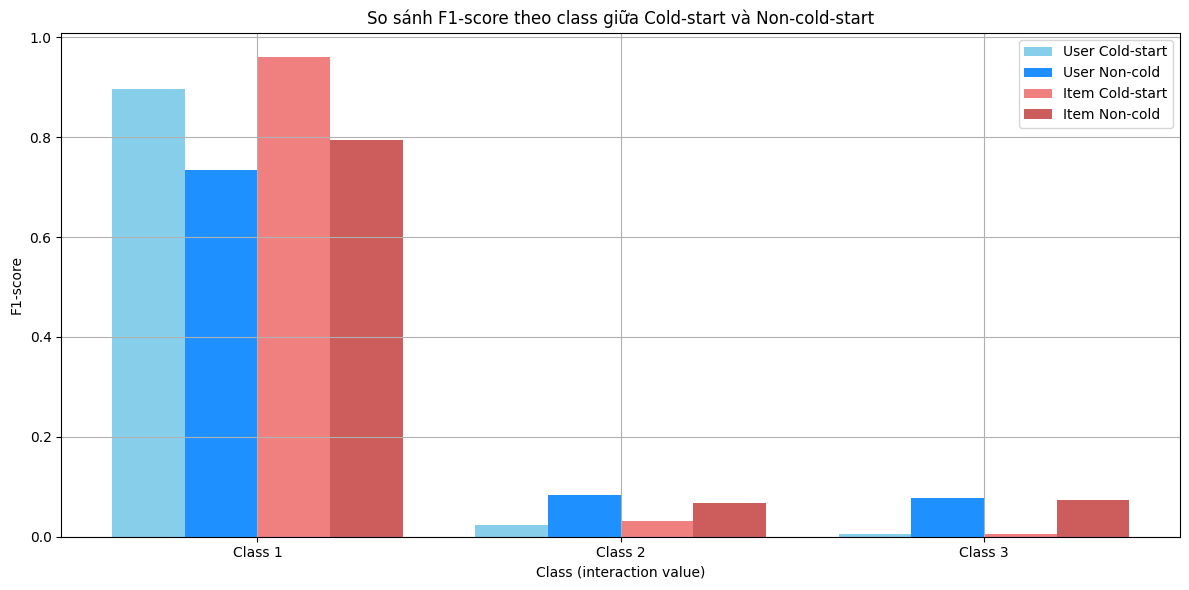

In [47]:
# Plot
labels = ['Class 1', 'Class 2', 'Class 3']
x = np.arange(len(labels))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - 1.5*width, f1_user_cold, width, label='User Cold-start', color='skyblue')
plt.bar(x - 0.5*width, f1_user_non_cold, width, label='User Non-cold', color='dodgerblue')
plt.bar(x + 0.5*width, f1_item_cold, width, label='Item Cold-start', color='lightcoral')
plt.bar(x + 1.5*width, f1_item_non_cold, width, label='Item Non-cold', color='indianred')

plt.xticks(x, labels)
plt.xlabel("Class (interaction value)")
plt.ylabel("F1-score")
plt.title("So sánh F1-score theo class giữa Cold-start và Non-cold-start")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print("\n📉 Loss theo nhóm:")
print(f" - User Cold-start: {focal_loss_with_class_weights(model, test_cold_user, y_test_cold_user):.4f}")
print(f" - Item Cold-start: {focal_loss_with_class_weights(model, test_cold_item, y_test_cold_item):.4f}")
print(f" - User Non-cold:   {focal_loss_with_class_weights(model, test_non_cold_user, y_test_non_cold_user):.4f}")
print(f" - Item Non-cold:   {focal_loss_with_class_weights(model, test_non_cold_item, y_test_non_cold_item):.4f}")

In [49]:
# Get list of cold-start users (users not present in the training set)
cold_start_users = list(test_cold_user["user_id"].unique())
print(f" - Number of cold-start users: {len(cold_start_users)}")

# Randomly select one cold-start user
if len(cold_start_users) == 0:
    print(" - No cold-start users found in the test set.")
else:
    sample_user = np.random.choice(cold_start_users)
    print(f"\n - Product recommendations for cold-start user: {sample_user}")

    # Get all rows from test_cold_user related to this user
    df_user = test_cold_user[test_cold_user["user_id"] == sample_user]

    if df_user.empty:
        print(f" - User {sample_user} has no interaction rows.")
    else:
        print(f" - Found {len(df_user)} interaction rows for this user.")

        # Prepare input for the model
        sample_inputs = prepare_input(df_user)

        # Predict
        predicted_probs = model.predict(sample_inputs, batch_size=128, verbose=0)

        # Top K products
        top_k = min(5, len(predicted_probs))
        top_indices = np.argsort(predicted_probs[:, 2])[-top_k:][::-1]

        print(f"\n - TOP {top_k} RECOMMENDED PRODUCTS FOR USER {sample_user} (COLD-START):")
        print("{:<10} {:<15} {:<10} {:<10} {:<15}".format(
            "No.", "Product ID", "View Prob", "Cart Prob", "Transaction Prob"))
        print("-" * 60)

        recommendations = []
        for i, idx in enumerate(top_indices, 1):
            product_id = sample_inputs[1][idx]
            probs = predicted_probs[idx]

            print("{:<10} {:<15} {:<10.2f} {:<10.2f} {:<15.2f}".format(
                i, product_id, probs[0], probs[1], probs[2]))

            recommendations.append({
                'user_id': sample_user,
                'item_id': product_id,
                'view_prob': float(probs[0]),
                'cart_prob': float(probs[1]),
                'transaction_prob': float(probs[2])
            })



 - Number of cold-start users: 208834

 - Product recommendations for cold-start user: 440645
 - Found 1 interaction rows for this user.

 - TOP 1 RECOMMENDED PRODUCTS FOR USER 440645 (COLD-START):
No.        Product ID      View Prob  Cart Prob  Transaction Prob
------------------------------------------------------------
1          188353          0.56       0.33       0.11           


# Compare with Hybrid LightFM vs LightFM Neutral Deep Learning

In [24]:
#  Chuẩn bị dữ liệu
all_data = pd.concat([train, valid, test]) 
def to_str(x, ndigits=4):
    return format(x, f'.{ndigits}f')

# Chuyển đổi các giá trị số thành chuỗi (string)
for col, ndigits in [
    ("age", 2),
    ("hour_sin", 4),
    ("hour_cos", 4),
    ("dayofweek_sin", 4),
    ("dayofweek_cos", 4),
    ("time_diff", 2),
    ("price", 2),
]:
    all_data[f"{col}_str"] = all_data[col].apply(lambda x: to_str(x, ndigits))
    train[f"{col}_str"] = train[col].apply(lambda x: to_str(x, ndigits))

all_user_ids = all_data["user_id"].unique()
all_item_ids = all_data["item_id"].unique()

# User features
user_features_list = np.unique([
    f"gender:{g}" for g in all_data["gender"].unique()
] + [
    f"age:{a}" for a in all_data["age_str"].unique()
] + [
    f"hour:{h}" for h in all_data["hour"].unique()
] + [
    f"dayofweek:{d}" for d in all_data["dayofweek"].unique()
] + [
    f"is_weekend:{w}" for w in all_data["is_weekend"].unique()
] + [
    f"hour_sin:{hs}" for hs in all_data["hour_sin_str"].unique()
] + [
    f"hour_cos:{hc}" for hc in all_data["hour_cos_str"].unique()
] + [
    f"dayofweek_sin:{ds}" for ds in all_data["dayofweek_sin_str"].unique()
] + [
    f"dayofweek_cos:{dc}" for dc in all_data["dayofweek_cos_str"].unique()
] + [
    f"time_diff:{td}" for td in all_data["time_diff_str"].unique()
] + [
    f"session_id:{sid}" for sid in all_data["session_id"].unique()
])

# Item features
item_features_list = np.unique([
    f"category:{c}" for c in all_data["category_id"].unique()
] + [
    f"parent_category:{pc}" for pc in all_data["parent_category"].unique()
] + [
    f"price:{p}" for p in all_data["price_str"].unique()
])

In [27]:
# Fit Dataset
dataset = Dataset()
dataset.fit(
    users=all_user_ids,
    items=all_item_ids,
    user_features=user_features_list,
    item_features=item_features_list
)

(interactions_train, _) = dataset.build_interactions(zip(train["user_id"], train["item_id"]))
(interactions_valid, _) = dataset.build_interactions(zip(valid["user_id"], valid["item_id"]))
(interactions_test, _) = dataset.build_interactions(zip(test["user_id"], test["item_id"]))

user_features = dataset.build_user_features([
    (uid, [
        f"gender:{g}",
        f"age:{a}",
        f"hour:{h}",
        f"dayofweek:{d}",
        f"is_weekend:{w}",
        f"hour_sin:{hs}",
        f"hour_cos:{hc}",
        f"dayofweek_sin:{ds}",
        f"dayofweek_cos:{dc}",
        f"time_diff:{td}",
        f"session_id:{sid}"
    ]) for uid, g, a, h, d, w, hs, hc, ds, dc, td, sid in zip(
        train["user_id"], train["gender"], train["age_str"], train["hour"], train["dayofweek"],
        train["is_weekend"], train["hour_sin_str"], train["hour_cos_str"],
        train["dayofweek_sin_str"], train["dayofweek_cos_str"], train["time_diff_str"], train["session_id"]
    )
])

item_features = dataset.build_item_features([
    (iid, [
        f"category:{c}",
        f"parent_category:{pc}",
        f"price:{p}"
    ]) for iid, c, pc, p in zip(
        train["item_id"], train["category_id"], train["parent_category"], train["price_str"]
    )
])

In [ ]:
num_threads = min(os.cpu_count(), 8)
# Khởi tạo mô hình
model_LightFM_hybrid = LightFM(no_components=128, loss='warp')

# Số epoch
epochs = 100

# Huấn luyện từng epoch và theo dõi tiến trình
for epoch in trange(epochs, desc="Training LightFM"):
    model_LightFM_hybrid.fit_partial(
        interactions_train,
        user_features=user_features,
        item_features=item_features,
        epochs=1,
        num_threads=num_threads
    )

In [ ]:
joblib.dump(model_LightFM_hybrid, 'lightfm_hybrid_model.pkl.pkl')

In [21]:
model_LightFM = joblib.load('/kaggle/input/lightfm_hybrid/other/default/1/LightFM_Hybrid/model_LightFM_hybrid.pkl')

In [28]:
print("Item features shape:", item_features.shape)
print("Model item embeddings shape:", model_LightFM.item_embeddings.shape)

print("User features shape:", user_features.shape)
print("Model user embeddings shape:", model_LightFM.user_embeddings.shape)

Item features shape: (235061, 236530)
Model item embeddings shape: (236530, 128)
User features shape: (1407580, 1870758)
Model user embeddings shape: (1870758, 128)


In [ ]:
# Lưu embeddings vào file .npy
np.save("user_embeddings_LightFM_hybrid.npy", model_LightFM_hybrid.user_embeddings)
np.save("item_embeddings_LightFM_hybrid.npy", model_LightFM_hybrid.item_embeddings)

In [38]:
from scipy.sparse import coo_matrix

def evaluate_lightfm_model(model, interactions, user_features=None, item_features=None, num_threads=4, k=5, sample_size=None):
    if sample_size is not None:
        # Random sample
        interaction_coo = interactions.tocoo()
        idx = np.random.choice(np.arange(interaction_coo.nnz), sample_size, replace=False)
        sampled = (interaction_coo.row[idx], interaction_coo.col[idx])
        interactions = coo_matrix((np.ones(sample_size), sampled), shape=interactions.shape)

    precision = precision_at_k(model, interactions,
                                user_features=user_features,
                                item_features=item_features,
                                k=k, num_threads=num_threads).mean()
    recall = recall_at_k(model, interactions,
                         user_features=user_features,
                         item_features=item_features,
                         k=k, num_threads=num_threads).mean()
    auc = auc_score(model, interactions,
                    user_features=user_features,
                    item_features=item_features,
                    num_threads=num_threads).mean()

    print(f" - Precision@{k}: {precision:.4f}")
    print(f" - Recall@{k}: {recall:.4f}")
    print(f" - AUC: {auc:.4f}")

    return {"precision": precision, "recall": recall, "auc": auc}

lightfm_results = evaluate_lightfm_model(model_LightFM,
                                         interactions_test,
                                         user_features=user_features,
                                         item_features=item_features,
                                         num_threads=4, k=5,
                                         sample_size=5000)

 - Precision@5: 0.0012
 - Recall@5: 0.0060
 - AUC: 0.8216


In [41]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import numpy as np

def evaluate_nn_model(model, X_test, y_test):
    # Dự đoán xác suất và lớp
    y_pred_prob = model.predict(X_test)
    y_pred_classes = y_pred_prob.argmax(axis=-1)
    
    # Chuyển y_test về dạng số nguyên nếu đang ở dạng one-hot
    if y_test.ndim > 1 and y_test.shape[1] > 1:
        y_test = y_test.argmax(axis=1)
    
    # Tính các metrics
    precision = precision_score(y_test, y_pred_classes, average='macro')
    recall = recall_score(y_test, y_pred_classes, average='macro')
    auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr', average='macro')
    
    print(f" - Precision (macro): {precision:.4f}")
    print(f" - Recall (macro): {recall:.4f}")
    print(f" - AUC (macro): {auc:.4f}")
    
    return {"precision": precision, "recall": recall, "auc": auc}

# Gọi hàm đánh giá
nn_results = evaluate_nn_model(model, X_test, y_test)

18532/18532 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step
 - Precision (macro): 0.3547
 - Recall (macro): 0.5306
 - AUC (macro): 0.7823


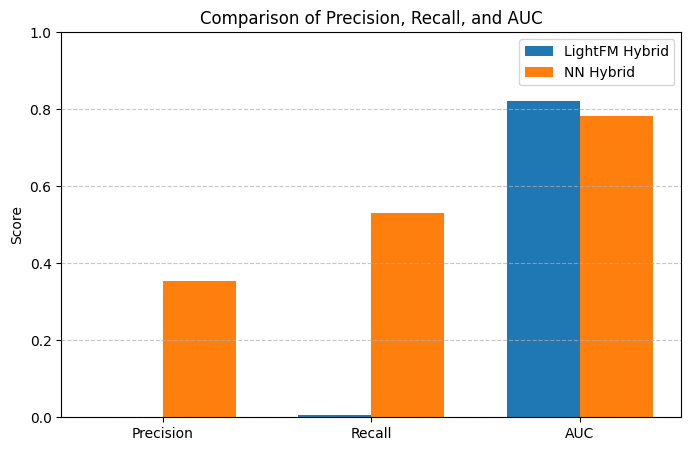

In [42]:
metrics = ['Precision', 'Recall', 'AUC']
lightfm_scores = [lightfm_results['precision'], lightfm_results['recall'], lightfm_results['auc']]
nn_scores = [nn_results['precision'], nn_results['recall'], nn_results['auc']]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, lightfm_scores, width, label='LightFM Hybrid')
plt.bar(x + width/2, nn_scores, width, label='NN Hybrid')

plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Comparison of Precision, Recall, and AUC')
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()